# OCR Agent from scratch:

* [Data](./Data-Sources.ipynb)
* [Utilities](./Data-Processing.ipynb)
* [Extract layout features and visual tokens](./Data-Extraction-2.ipynb)
* [Generate training data](./Data-Extraction-3.ipynb)
* Model architecture
    * [Visual encoder, generative and discriminative heads](./Model-Backbone.ipynb)
    * [Unsupervised and semi-supervise pretraining](./Model-Pretraining.ipynb)
    * Supervised multi-task training
* [Traversal strategies](./Traversal-Layout.ipynb)
* [Reader Agent](./Agent-LM.ipynb)
* [Leverage synthetic training data](./Data-Gen.ipynb)
* [Optimization for production](./Optimization.ipynb)


### Multi-task training with pretrained encoder

We have a trained encoder with denoising and orientation detection heads. Let's train character recognition.

Having uncertain `num_classes`, we build a classifier with some "extensibility": we keep the index of the *known* symbols and append new as they arrive up to some reasonable capacity we can handle. New entries expected to arrive in the order of their frequencies (first, they appear as `unknown`).
This index we will use as our class-index: it means our classifier will have some fuzzy tail expected tighten up with time.

`Semantics` in this case we define as the target symbol position type: `middle of word`, `word head`, `word tail`, and `single stand` -- we need that for the proper word-aggregation. We can add it as `ContextClassifier`, another way would be `target`+`context` consensus.

In [1]:
import json
import torch
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim import SGD, AdamW
from torchsummary import summary
from torchmetrics import ConfusionMatrix

In [2]:
from scripts.training import *

In [3]:
torch.cuda.empty_cache()
print('GPU' if DEVICE == 'cuda' else 'no GPU')

GPU


<a name="data"></a>

## Dataset

In [4]:
# show current index
''.join(INDEX)

' aeongsitfmpudlcrPbv(h2C1.)xSI-,DyFRA0EB34N5Tq6M7L98wUzOGjk\'H/YéàV•:☐$J%èQêWç?ôZù»+K;▶X◀É"*ûâÀ°&▲«[îÎ]œ=✓#Ô±½@È¼§Êº▼ó>≤ñ!áäìöÂ_¢÷Œ¾ü{ú}©ëåÇí'

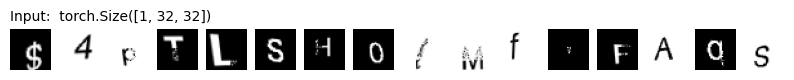

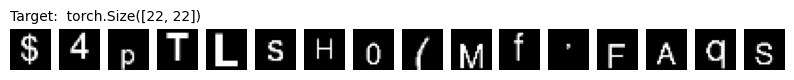

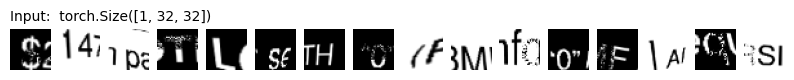

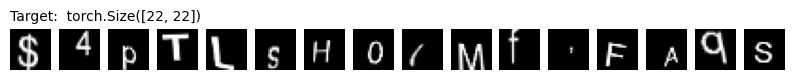

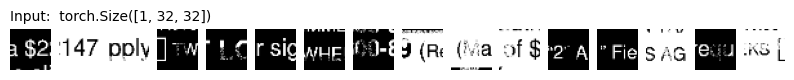

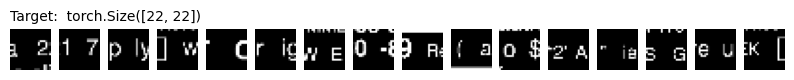

tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 2, 2, 1, 1, 0, 2])


In [5]:
source = np.random.choice(testset)

# pick the batch for evaluation
for demo_batch in DataLoader(MultitaskDataset(source, INDEX, transform=1.), batch_size=16, shuffle=True):
    X, Y, L = demo_batch
    for i in range(len(X)):
        show_inputs(X[i])
        show_targets(Y[i])
    break
print(L[-3])

In [6]:
semantic_labels = pd.read_csv('./data/context-weight.csv')
semantic_weight = semantic_labels['weight'].to_list()
semantic_labels = semantic_labels['name'].to_list()
semantic_dim = len(semantic_labels)
semantic_dim, semantic_labels

(5, ['mid', 'head', 'tail', 'single', 'empty'])

<a name="exp"></a>

## Model

In [7]:
latent_dim = 64
num_classes = len(INDEX)

encoder = get_encoder()
# use pretrained
encoder.load_state_dict(torch.load('./models/backbone-encoder.pt'))
# freeze it
for param in encoder.parameters():
    param.requires_grad = False

model = MultiVAE(encoder, latent_dim, num_classes).to(DEVICE)

keys = model.keys
for i, out in enumerate(model([x.to(DEVICE) for x in X])):
    print(keys[i], out.size() if out is not None else 'NaN')

concept-rec torch.Size([16, 1, 22, 22])
concept-z torch.Size([16, 64])
concept-mean torch.Size([16, 64])
concept-log-var torch.Size([16, 64])
concept-tau torch.Size([1])
concept-z-context torch.Size([16, 64])
concept-label torch.Size([16, 156])
target-rec torch.Size([16, 1, 22, 22])
target-z torch.Size([16, 64])
target-mean torch.Size([16, 64])
target-log-var torch.Size([16, 64])
target-tau torch.Size([1])
target-z-context torch.Size([16, 64])
target-label torch.Size([16, 156])
context-rec torch.Size([16, 1, 22, 22])
context-z torch.Size([16, 64])
context-mean torch.Size([16, 64])
context-log-var torch.Size([16, 64])
context-tau torch.Size([1])
context-z-context torch.Size([16, 64])
context-label torch.Size([16, 156])


In [8]:
semantic = ContextClassifier(keys, latent_dim, semantic_dim)
model = MultiVAE(encoder, latent_dim, num_classes, semantic=semantic, align=True, neighbors=True).to(DEVICE)

for i, out in enumerate(model([x.to(DEVICE) for x in X])):
    print(model.keys[i], out.size() if out is not None else 'NaN')

concept-rec torch.Size([16, 1, 22, 22])
concept-z torch.Size([16, 64])
concept-mean torch.Size([16, 64])
concept-log-var torch.Size([16, 64])
concept-tau torch.Size([1])
concept-z-context torch.Size([16, 64])
concept-label torch.Size([16, 156])
target-rec torch.Size([16, 1, 22, 22])
target-z torch.Size([16, 64])
target-mean torch.Size([16, 64])
target-log-var torch.Size([16, 64])
target-tau torch.Size([1])
target-z-context torch.Size([16, 64])
target-label torch.Size([16, 156])
context-rec torch.Size([16, 1, 22, 22])
context-z torch.Size([16, 64])
context-mean torch.Size([16, 64])
context-log-var torch.Size([16, 64])
context-tau torch.Size([1])
context-z-context torch.Size([16, 64])
context-label torch.Size([16, 156])
semantic torch.Size([16, 5])
align torch.Size([16, 1, 22, 22])
left torch.Size([16, 156])
right torch.Size([16, 156])


## Training

In [9]:
VAE(get_encoder(), get_decoder(), latent_dim).keys

['rec', 'z', 'mean', 'log-var', 'tau', 'z-context', 'label']

In [10]:
class MultitaskLoss(nn.Module):
    tags = ['concept','target','context'] # model-components
    order = ['label','semantic','left','right'] # labels
    
    def __init__(self, keys: list, config: dict,
                       label_align: nn.Module, semantic_align: nn.Module,
                       weight: dict, trainable: bool = False):
        super().__init__()
        self.keys = keys
        keys = ['rec','z','mean','log-var','tau','z-context','label'] # all VAE outputs
        for tag in self.tags:
            setattr(self, tag, VAELoss(keys, config[tag], align=label_align))
        self.semantic = semantic_align
        self.align = ReconstructionLoss()
        self.neighbor = label_align #nn.CrossEntropyLoss()
        # consensus classifiers weight
        weight = [weight[k] if k in weight else 0. for k in ['semantic','align','neighbors']]
        self.weight = nn.Parameter(torch.Tensor(weight)) if trainable else torch.Tensor(weight)
        self.trainable = trainable
        
    def forward(self, outputs, targets, labels):
        loss, metrics = [], {}
        # encoders-align
        for i, tag in enumerate(['concept','target','context']):
            r, l = self.keys.index(f'{tag}-rec'), self.keys.index(f'{tag}-label')
            tag_loss, tag_metrics = getattr(self, tag)(outputs[r:l + 1], targets[i], labels[0])
            metrics = {**metrics, **{f'{tag}-{k}':v for k,v in tag_metrics.items()}}
            loss.append(tag_loss)
        # consensus classifiers
        semantic_loss = self.semantic(outputs[self.keys.index('semantic')], labels[1])
        loss.append(semantic_loss * torch.exp(self.weight[0]))
        metrics['semantic'] = semantic_loss.item()
        # discriminator loop
        align_loss = self.align(outputs[self.keys.index('align')], targets[self.tags.index('concept')]).squeeze()
        loss.append(align_loss * torch.exp(self.weight[1]))
        metrics['align'] = align_loss.item()
        # context neighbors
        for i, side in enumerate(['left','right']):
            side_loss = self.neighbor(outputs[self.keys.index(side)], labels[self.order.index(side)])
            loss.append(side_loss * torch.exp(self.weight[2]))
            metrics[side] = side_loss.item()
        loss = torch.sum(torch.stack(loss))
        if self.trainable:
            # balance component-model vs. consensus plus regularization
            loss += torch.sum(self.weight.pow(4))
        return loss, metrics


In [11]:
SOURCE = 'training'

In [ ]:
PATH = f'VAE-multi-{latent_dim}-{num_classes}-{semantic_dim}-frozen'
#model.load_state_dict(torch.load(f'./models/{PATH}.pt'))

In [ ]:
batch_size = 16
learning_rate = 5e-6
epochs = 10
start = 1

label_weight = torch.Tensor(WEIGHT).to(DEVICE)
label_align = nn.CrossEntropyLoss(weight=label_weight)

semantic_align = nn.CrossEntropyLoss(weight=torch.Tensor(semantic_weight).to(DEVICE))
#context = nn.BCEWithLogitsLoss()

config = {'concept': {'Reconstruction':8., 'KLD':-2., 'Contrast':0., 'Align':5.},
          'target':  {'Reconstruction':8., 'KLD':-3., 'Contrast':1., 'Align':5.},
          'context': {'Reconstruction':8., 'KLD':-4., 'Contrast':2., 'Align':5.}}

consensus = {'semantic':5., 'align':8., 'neighbors':3.}

criterion = MultitaskLoss(model.keys, config, label_align, semantic_align, consensus).to(DEVICE)
#criterion.load_state_dict(torch.load(f'./models/{PATH}-criterion.pt'))

params = [p for p in model.parameters()] + [p for p in criterion.parameters()]
optimizer = SGD(params, lr=learning_rate, momentum=0.9)
#optimizer.load_state_dict(torch.load(f'./models/{PATH}-optimizer.pt'))

history = {'train':[],'test':[]}
for epoch in range(start, epochs + 1):
    for i, source in enumerate(np.random.permutation(trainset), 1):
        train_history = train(model, MultitaskDataset(source, INDEX, path=SOURCE),
                              criterion, optimizer, batch_size=batch_size)
        test_history = validate(model, MultitaskDataset(np.random.choice(testset), INDEX, path=SOURCE),
                                criterion, batch_size=batch_size)
        # track epoch avg loss
        history['train'].append(pd.DataFrame.from_dict(train_history).mean().to_dict())
        history['test'].append(pd.DataFrame.from_dict(test_history).mean().to_dict())
        print(f"Epoch {epoch}: {i/len(trainset):<7.2%}  "
              f"train: {history['train'][-1]['Loss']:<5.0f}  "
              f"test: {history['test'][-1]['Loss']:<5.0f}  "
              f"context: {history['test'][-1]['context-Align']:<5.2f}  "
              f"left: {history['test'][-1]['left']:<5.2f}  "
              f"right: {history['test'][-1]['right']:<5.2f}  "
              f"semantic: {history['test'][-1]['semantic']:<.2f}  "
              , end='\r')

    torch.save(model.state_dict(), f'./models/{PATH}.pt')
    with open(f'./output/{PATH}-{epoch}.json','w') as output:
        json.dump(history, output)
        history = {'train':[],'test':[]}

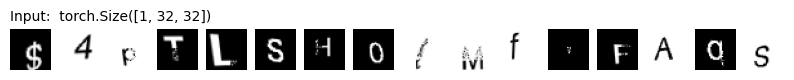

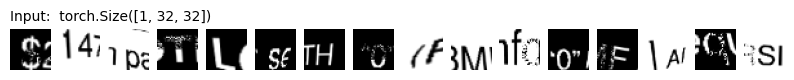

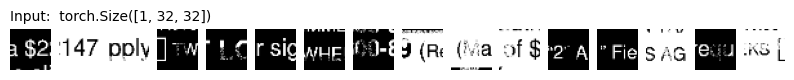


------- concept output -------------------------------------------


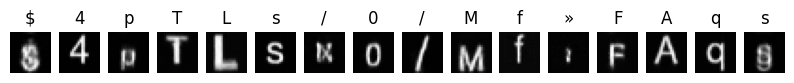


------- target  output -------------------------------------------


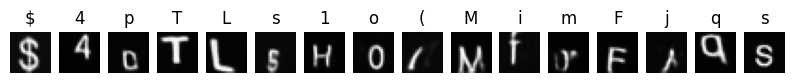


------- context output -------------------------------------------


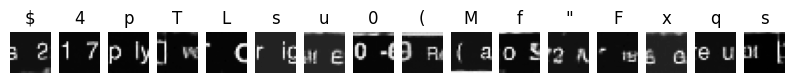

In [14]:
torch.save(criterion.state_dict(), f'./models/{PATH}-criterion.pt')
torch.save(optimizer.state_dict(), f'./models/{PATH}-optimizer.pt')

# release for online learning
torch.save(model.state_dict(), f"./models/{PATH.replace('frozen','online')}.pt")

plot_results(PATH, window=100 * epoch, save=True)

X, Y, L = demo_batch
show_inputs(X[0])
show_inputs(X[1])
show_inputs(X[2])
with torch.no_grad():
    model.eval()
    n = len(X[0])
    output = model([x.to(DEVICE) for x in X])
    for j, m in enumerate(model.tags):
        print(f'\n------- {m:<7} output -------------------------------------------')
        a, b = model.keys.index(f'{m}-rec'), model.keys.index(f'{m}-label')
        fig, ax = plt.subplots(1, n, figsize=(10, 10))
        R = output[a].cpu().squeeze().numpy()
        P = np.argmax(torch.softmax(output[b], dim=1).cpu().squeeze().numpy(), axis=1)
        for i in range(n):
            ax[i].imshow(R[i,:], 'gray')
            ax[i].set_title(INDEX[P[i]])
            ax[i].axis('off')
        plt.show()

## Evaluation

In [15]:
label_confmat = ConfusionMatrix(task='multiclass', num_classes=num_classes).to(DEVICE)
semantic_confmat = ConfusionMatrix(task='multiclass', num_classes=semantic_dim).to(DEVICE)

label_matrix = [np.zeros((num_classes, num_classes)) for _ in range(len(model.tags) + 2)]
semantic_matrix = np.zeros((semantic_dim, semantic_dim))

model.eval()
with torch.no_grad():
    for source in testset:
        loader = DataLoader(MultitaskDataset(source, INDEX, path=SOURCE), batch_size=16)
        for batch in loader:
            X, Y, L = batch
            n = len(X[0])
            output = model([x.to(DEVICE) for x in X])
            for i, tag in enumerate(model.tags):
                P = torch.argmax(torch.softmax(output[model.keys.index(f'{tag}-label')], dim=1), dim=1)
                label_matrix[i] += label_confmat(P, L[0].to(DEVICE)).cpu().numpy()
            for i, side in enumerate(['left','right'], len(model.tags)):
                P = torch.argmax(torch.softmax(output[model.keys.index(side)], dim=1), dim=1)
                label_matrix[i] += label_confmat(P, L[i - 1].to(DEVICE)).cpu().numpy()                    
            P = torch.argmax(torch.softmax(output[model.keys.index('semantic')], dim=1), dim=1)
            semantic_matrix += semantic_confmat(P, L[1].to(DEVICE)).cpu().numpy()

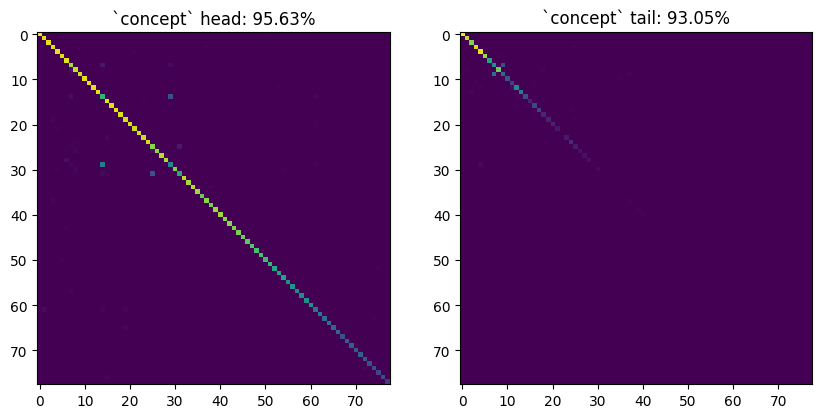

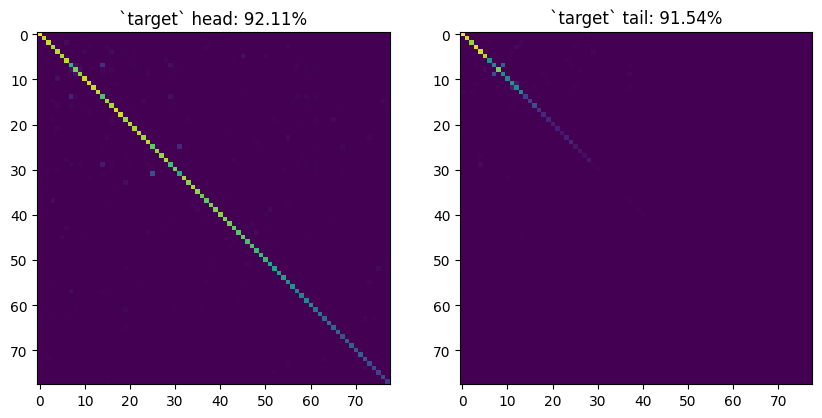

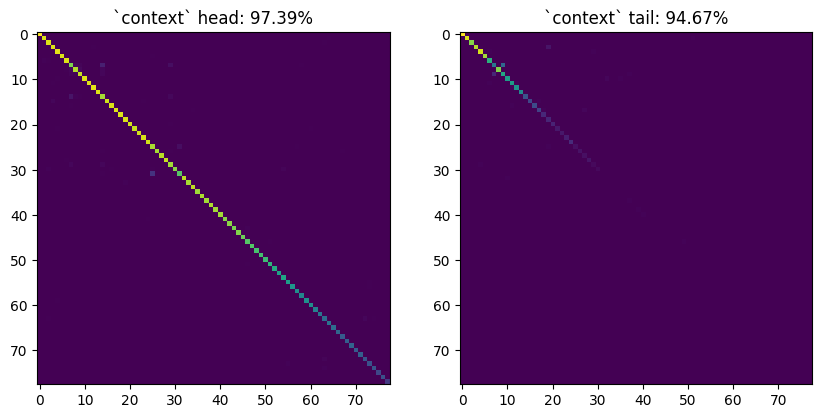

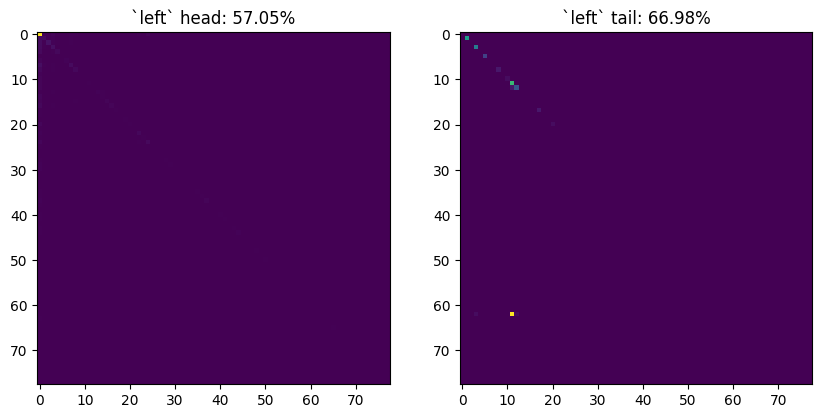

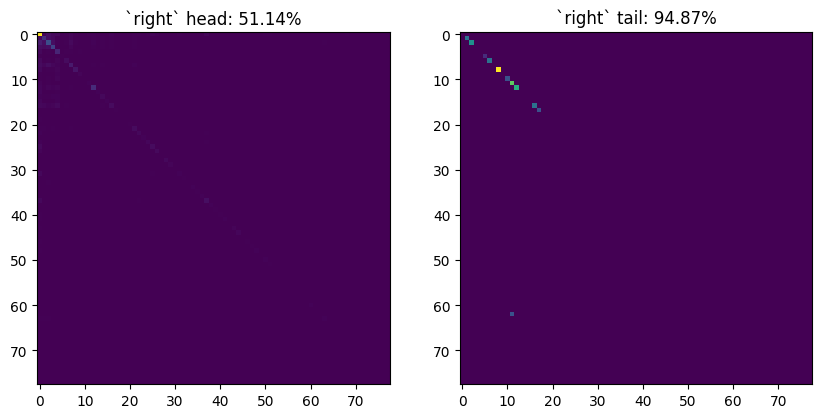

In [16]:
for i, tag in enumerate(model.tags + ['left','right']):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    a, b = num_classes//2, num_classes
    ax[0].imshow(label_matrix[i][:a,:a])
    ax[0].set_title(f'`{tag}` head: {label_matrix[i][:a,:a].trace()/label_matrix[i][:a,:a].sum():.2%}')
    ax[1].imshow(label_matrix[i][a:b,a:b])
    ax[1].set_title(f'`{tag}` tail: {label_matrix[i][a:b,a:b].trace()/label_matrix[i][a:b,a:b].sum():.2%}')
    plt.savefig(f'./output/{PATH}-{tag}.png')
    plt.show()

In [17]:
# check what's most missclassified
def get_rates(confmat):
    n = len(INDEX)
    pairs = [[a, b, confmat[a,b]] for a, b in np.transpose(confmat[:n,:n].nonzero())]
    pairs = pd.DataFrame(pairs, columns=['char-1','char-2','count'])
    pairs = pairs.merge(pairs.groupby('char-1').sum()['count'].rename('total').reset_index(), on='char-1')
    pairs['%rate'] = 100 * pairs['count']/pairs['total']
    pairs = pairs.loc[pairs['count'] > 1]
    pairs['char-1'] = pairs['char-1'].apply(lambda x:INDEX[x])
    pairs['char-2'] = pairs['char-2'].apply(lambda x:INDEX[x])
    return (pairs[pairs['char-1']==pairs['char-2']].set_index(['char-1','char-2']),
            pairs[pairs['char-1']!=pairs['char-2']].set_index(['char-1','char-2']))


In [18]:
# concept classification tail (less certain)
goals, misses = get_rates(label_matrix[0])
goals.sort_values('%rate', ascending=False).tail(10).astype(int).style.background_gradient('Greens')

,,count,total,%rate
char-1,char-2,,,
;,;,72,100,72
Ô,Ô,5,7,71
l,l,555,816,68
▶,▶,61,90,67
",",",",514,769,66
I,I,386,771,50
◀,◀,41,89,46
É,É,33,74,44
À,À,12,27,44


In [19]:
misses.sort_values('%rate', ascending=False).head(10).astype(int).style.background_gradient('Reds')

,,count,total,%rate
char-1,char-2,,,
¾,%,2,2,100
±,+,3,4,75
Î,I,6,8,75
É,E,40,74,54
"""",',39,74,52
À,A,14,27,51
◀,▶,44,89,49
I,l,347,771,45
▶,◀,29,90,32


In [20]:
# target classification tail (less certain)
goals, misses = get_rates(label_matrix[1])
goals.sort_values('%rate', ascending=False).tail(10).astype(int).style.background_gradient('Greens')

,,count,total,%rate
char-1,char-2,,,
[,[,9,13,69
",",",",522,769,67
=,=,6,9,66
#,#,4,6,66
½,½,2,3,66
i,i,543,826,65
◀,◀,55,89,61
&,&,16,27,59
;,;,59,100,59


In [21]:
misses.sort_values('%rate', ascending=False).head(10).astype(int).style.background_gradient('Reds')

,,count,total,%rate
char-1,char-2,,,
¾,%,2,2,100
±,+,3,4,75
▶,◀,36,90,40
◀,▶,28,89,31
;,:,30,100,30
É,E,22,74,29
",",.,207,769,26
[,(,3,13,23
&,8,6,27,22


In [22]:
# context classification tail (less certain)
goals, misses = get_rates(label_matrix[2])
goals.sort_values('%rate', ascending=False).tail(10).astype(int).style.background_gradient('Greens')

,,count,total,%rate
char-1,char-2,,,
î,î,8,9,88
&,&,24,27,88
#,#,5,6,83
i,i,681,826,82
◀,◀,73,89,82
",",",",627,769,81
;,;,78,100,78
±,±,3,4,75
=,=,5,9,55


In [23]:
misses.sort_values('%rate', ascending=False).head(10).astype(int).style.background_gradient('Reds')

,,count,total,%rate
char-1,char-2,,,
Ç,C,2,2,100
¾,N,2,2,100
▶,◀,41,90,45
=,-,2,9,22
;,:,18,100,18
",",.,124,769,16
◀,▶,13,89,14
i,l,76,826,9
&,#,2,27,7


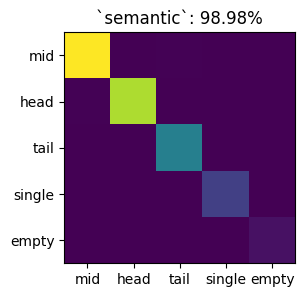

In [24]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(semantic_matrix)
ax.set_xticks(range(semantic_dim))
ax.set_yticks(range(semantic_dim))
ax.set_xticklabels(semantic_labels)
ax.set_yticklabels(semantic_labels)
ax.set_title(f'`semantic`: {semantic_matrix.trace()/semantic_matrix.sum():.2%}')
plt.savefig(f'./output/{PATH}-semantic.png')
plt.show()

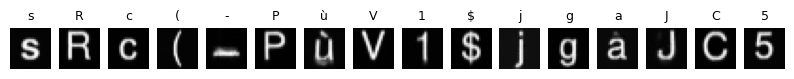

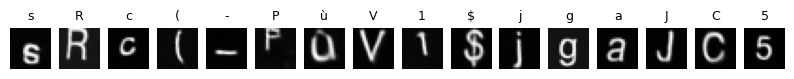

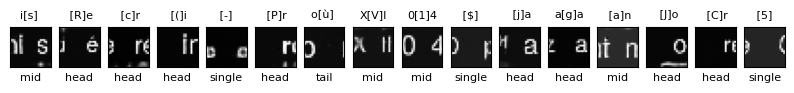

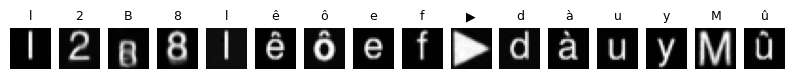

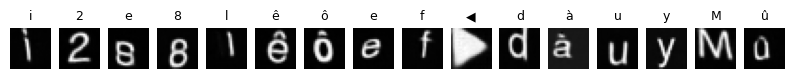

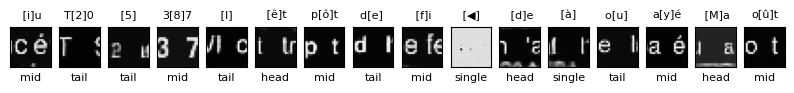

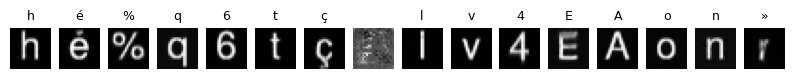

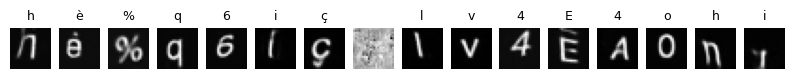

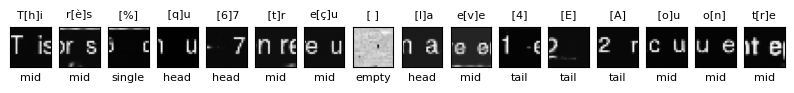

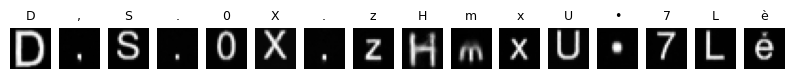

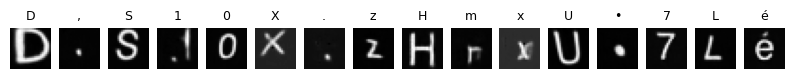

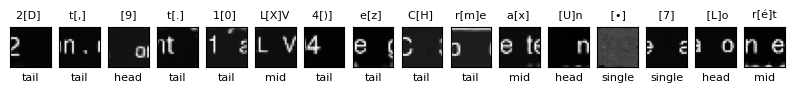

In [25]:
model.eval()
with torch.no_grad():
    source = np.random.choice(testset)
    #loader = DataLoader(MultitaskDataset(source, INDEX, path=SOURCE, amp=16), batch_size=16) # full batch of each
    loader = DataLoader(MultitaskDataset(source, INDEX, path=SOURCE), batch_size=16)
    for X, Y, _ in loader:
        n = len(X[0])
        if n < 16: break
        output = model([x.to(DEVICE) for x in X])
        S = np.argmax(torch.softmax(output[model.keys.index('semantic')], dim=1).cpu().squeeze().numpy(), axis=1)
        left = np.argmax(torch.softmax(output[model.keys.index('left')], dim=1).cpu().squeeze().numpy(), axis=1)
        right = np.argmax(torch.softmax(output[model.keys.index('right')], dim=1).cpu().squeeze().numpy(), axis=1)
        for j, m in enumerate(model.tags):
            a, b = model.keys.index(f'{m}-rec'), model.keys.index(f'{m}-label')
            fig, ax = plt.subplots(1, 16, figsize=(10, 10))
            R = output[a].cpu().squeeze().numpy()
            P = np.argmax(torch.softmax(output[b], dim=1).cpu().squeeze().numpy(), axis=1)
            for i in range(16):
                ax[i].imshow(R[i,:], 'gray')
                if m == 'context':
                    ax[i].set_title(f'{INDEX[left[i]]}[{INDEX[P[i]]}]{INDEX[right[i]]}', fontsize=8)
                    ax[i].set_xlabel(semantic_labels[S[i]], fontsize=8)
                    ax[i].set_xticks([])
                    ax[i].set_yticks([])
                else:
                    ax[i].set_title(INDEX[P[i]], fontsize=9)
                    ax[i].axis('off')
            plt.savefig(f'./output/{PATH}-eval.png')
            plt.show()
        print(' ')

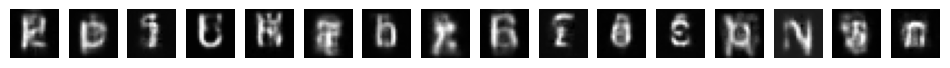

In [26]:
# generate some `concept` samples
model.eval()
with torch.no_grad():
    samples = model.concept.sample(16).squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 16, figsize=(12, 12))
    for i in range(16):
        ax[i].imshow(samples[i,:], 'gray')
        ax[i].axis('off')
    plt.show()

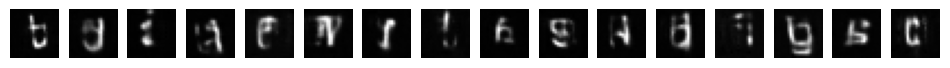

In [27]:
# generate some `focus` samples
model.eval()
with torch.no_grad():
    samples = model.target.sample(16).squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 16, figsize=(12, 12))
    for i in range(16):
        ax[i].imshow(samples[i,:], 'gray')
        ax[i].axis('off')
    plt.show()

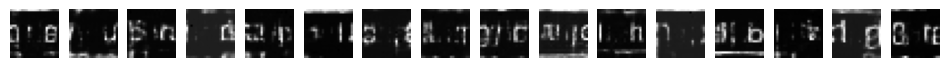

In [28]:
# generate some `context` samples
model.eval()
with torch.no_grad():
    samples = model.context.sample(16).squeeze().cpu().numpy()
    fig, ax = plt.subplots(1, 16, figsize=(12, 12))
    for i in range(16):
        ax[i].imshow(samples[i,:], 'gray')
        ax[i].axis('off')
    plt.show()